Dataset link: https://www.kaggle.com/datasets/mukeshmanral/fifa-data-for-eda-and-stats 

<h1>Recommendation system for Sports owner</h1>

Futbol is a sport enjoyed internationallt, so much so that Futbol players are the most paid and recognized athletes in the global stage. With each team's roster there will always be some that out perform or capture the crowds heart. Naturally many people are fans of many different players. Using NearestNeighbors and Cosine distance, I hope to make a recommendation system for fans based on their favorite player.

For this system, ofcourse I would use numpy, pandas, seaborn, matplot, and sklearn. But ontop of that I will need to use random to create unbiased samples, StandardScaler to make each feature comparable to each other, PCA to optimize and remove complexity, and TSNE to lower dimensianality.

In [11]:
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

I will use our FIFA dataset, and as you can see our dataset is a mix of numerical and catagorical entries. With many columns and many entires, I hope that the information provided is substancial enough to draw comperisons between players

In [2]:
fifa = pd.read_csv("fifa_eda_stats.csv")
fifa.head()
fifa.info()
fifa.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Name                      18207 non-null  object 
 2   Age                       18207 non-null  int64  
 3   Nationality               18207 non-null  object 
 4   Overall                   18207 non-null  int64  
 5   Potential                 18207 non-null  int64  
 6   Club                      17966 non-null  object 
 7   Value                     18207 non-null  object 
 8   Wage                      18207 non-null  object 
 9   Preferred Foot            18159 non-null  object 
 10  International Reputation  18159 non-null  float64
 11  Weak Foot                 18159 non-null  float64
 12  Skill Moves               18159 non-null  float64
 13  Work Rate                 18159 non-null  object 
 14  Body T

['ID',
 'Name',
 'Age',
 'Nationality',
 'Overall',
 'Potential',
 'Club',
 'Value',
 'Wage',
 'Preferred Foot',
 'International Reputation',
 'Weak Foot',
 'Skill Moves',
 'Work Rate',
 'Body Type',
 'Position',
 'Jersey Number',
 'Joined',
 'Loaned From',
 'Contract Valid Until',
 'Height',
 'Weight',
 'Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'StandingTackle',
 'SlidingTackle',
 'GKDiving',
 'GKHandling',
 'GKKicking',
 'GKPositioning',
 'GKReflexes',
 'Release Clause']

First I got drop some irrevelant columns that are not conductive to fan's preference. ID is not needed for obviouse reasons. Loaned from, realese clause, and contract valid until are matters in which rarely look for in a player. Further more, while these career related features might be indicative of career trajectory, their indirect measures of success and pale in comperison to wages, overall performance, and logivity.

For this recommendation system, I dont want to simply exclude players because they may lack and documented wage, age, foot position, or because they moight not be signed with a league. This means that I must find an intuative way to fill these gaps with a estimated guess. I must find the columns with missing values and quantify how much they might be missing.

A problem occured with the formating of certain numerical values, in order to indicate the measure of unit for some of these numerical features they must be stored as a string. Starting with wage and value, as far as I can see every monetary value is in Euro, so I just need to replace € with and empty space and turn the value into a numeric. Unfortunatly you do need to keep account of whether the monetary value is in form of millions, thousands, and less than. Doing this you add the appropriate muliplyer to the Euro amount and return its numeric value. For weights its the same initial approach as to the monetary value but instead you replace the lbs measurement. Height is a bit more trickier, since all height measurement includes ' you can split the sting into two strings, one in feet and the other in inches. You convert the feet into inches, and added to the other inch amount. Then you convert this sum into centimeters as it is a prefered height mesurement compared to the imperial system.

Now we can fill the wholes with a widly adopted strategy of using the avarage value for each column, in the case for categorical values N/A is a suffient marker for inconclusive values

Then we make sure that no duplicates are in the dataset, as they are redundant and we always keep the first instance of a duplicate. 

Lastly we standerize all our numerical values, so we minimize imbalances in our comperisons.

In [3]:
players = fifa.drop(columns=['ID', 'Loaned From', 'Release Clause', 'Contract Valid Until'])
Nas = pd.DataFrame()
for col in players:
    if players[col].isnull().sum() > 0:
        Nas[col] = players[col]
print(f"Total columns with missing values: {len(Nas.columns.tolist())}")
print("Columns with missing values:")
print(Nas.isnull().sum())

def to_num(s):
    try:
        if "'" in s:
            num = s.split("'")
            inches = float(num[0]) * 12 + float(num[1])
            s = inches * 2.54
        if "lbs" in s:
            s = float(s.replace('lbs', ''))
        if '€' in s:
            s = s.replace('€', '')
            if 'M' in s:
                s = float(s.replace('M', '')) * 1000000
            elif 'K' in s:
                s = float(s.replace('K', '')) * 1000
            else: 
                s = float(s)
        return s
    except:
        return None
players['Wage'] = players['Wage'].apply(to_num)
players['Value'] = players['Value'].apply(to_num)
players['Height'] = players['Height'].str.replace("'", ".").astype(float)
players['Weight'] = players['Weight'].str.replace('lbs', '').astype(float)

numeric_cols = players.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    players[col].fillna(players[col].median(), inplace=True)
categorical_cols = players.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    players[col].fillna("N/A", inplace=True)
print(f"Total columns with missing values after processing: 0")
initial_count = len(players)
players.drop_duplicates(inplace=True, keep='first')
duplicates_removed = initial_count - len(players)
print(f"Total duplicate rows removed: {duplicates_removed}")
players_original = players.copy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(players[numeric_cols])
scaled_df = pd.DataFrame(scaled_features, columns = [f'{col}_scaled' for col in numeric_cols], index = players.index)
players = pd.concat([players, scaled_df], axis=1)
print(f"Scaled {len(numeric_cols)} numeric featrures")
print("\n====processed data=====")
players.head()

Total columns with missing values: 46
Columns with missing values:
Club                         241
Preferred Foot                48
International Reputation      48
Weak Foot                     48
Skill Moves                   48
Work Rate                     48
Body Type                     48
Position                      60
Jersey Number                 60
Joined                      1553
Height                        48
Weight                        48
Crossing                      48
Finishing                     48
HeadingAccuracy               48
ShortPassing                  48
Volleys                       48
Dribbling                     48
Curve                         48
FKAccuracy                    48
LongPassing                   48
BallControl                   48
Acceleration                  48
SprintSpeed                   48
Agility                       48
Reactions                     48
Balance                       48
ShotPower                     48
Jumping  

C:\Users\holyw\AppData\Local\Temp\ipykernel_20144\819550659.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  players[col].fillna(players[col].median(), inplace=True)
C:\Users\holyw\AppData\Local\Temp\ipykernel_20144\819550659.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Total columns with missing values after processing: 0
Total duplicate rows removed: 0
Scaled 45 numeric featrures

====processed data=====


,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,...,Penalties_scaled,Composure_scaled,Marking_scaled,StandingTackle_scaled,SlidingTackle_scaled,GKDiving_scaled,GKHandling_scaled,GKKicking_scaled,GKPositioning_scaled,GKReflexes_scaled
0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,Left,5.0,...,1.686561,3.270147,-0.719159,-0.911222,-0.925466,-0.599836,-0.318445,-0.073911,-0.139573,-0.484898
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,Right,5.0,...,2.324197,3.182588,-0.970671,-0.772577,-1.066557,-0.543255,-0.318445,-0.073911,-0.139573,-0.317611
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,Right,5.0,...,2.069143,3.095030,-1.020973,-1.096081,-0.596255,-0.430094,-0.436883,-0.073911,-0.080798,-0.317611
3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,Right,4.0,...,-0.545165,0.818511,-1.624602,-1.234726,-1.536858,4.152944,4.063781,4.294272,4.209793,4.310642
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,Right,4.0,...,1.941616,2.569679,1.041426,0.475223,0.250288,-0.090609,-0.200006,-0.680603,-0.374674,-0.206087


Here we will display a few statistics from our dataset so we can surmize a few points of comparisons. We these relations, we can create a few vizualizations that can inform our understanding of the data.

I was surpized by the result of the dataset, so much so that I had to play around with the order and different measure to prove its consistancy. As you will later see, The most abundant nationalities are the English, Spaniard, Argentinian, and German demographic. So much so that because there is so many of these players, the avarage will be much lower as there wil always be more bad players than stellar players in terms of overall performance. So the natialities with the lower representation, but impressive stats will be considered the better performing nationality on avarage.

The pie chart shows that the most represented nationalities in this dataset, comes from the most recognized (and probably better unded) countries in the sport. I had to every country with a representation of 2% as other, for clarity sakes.

This heatmap pits every feature agianst each other, interestingly the most hottest areas of the map are the intersetctions of features between height, and GKDivinng. This suggest that the features most closely related to game permance are heavily coorelated. Another thing of note that any other feature that aren't superfluous to actual game performance (such as Jersey number, height and the GK measures) are in some ways corralted.

total number of players: 18207
number of unique clubs: 652
number of unique nationalities: 164
club with highest average wage:
 Club
Real Madrid          152030.303030
FC Barcelona         146575.757576
Juventus             131680.000000
Manchester City      113363.636364
Manchester United    102757.575758
                         ...      
Lokomotiv Moscow       1000.000000
Envigado FC            1000.000000
Kaizer Chiefs          1000.000000
Sligo Rovers           1000.000000
N/A                       0.000000
Name: Wage, Length: 652, dtype: float64


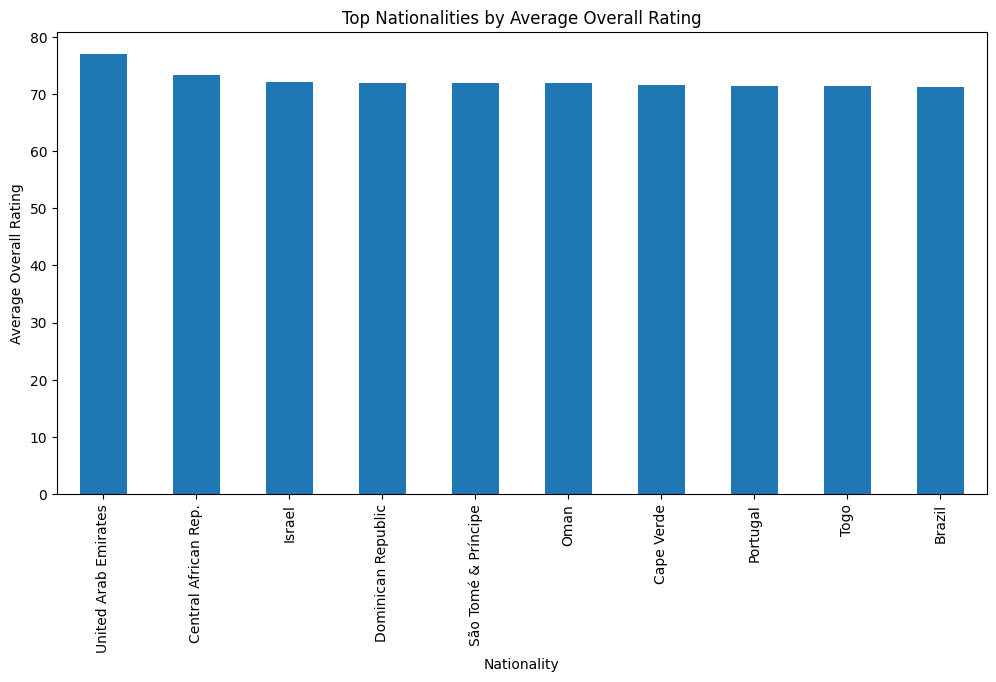

Text(0.5, 1.0, 'Correlation Matrix of Numeric Features')

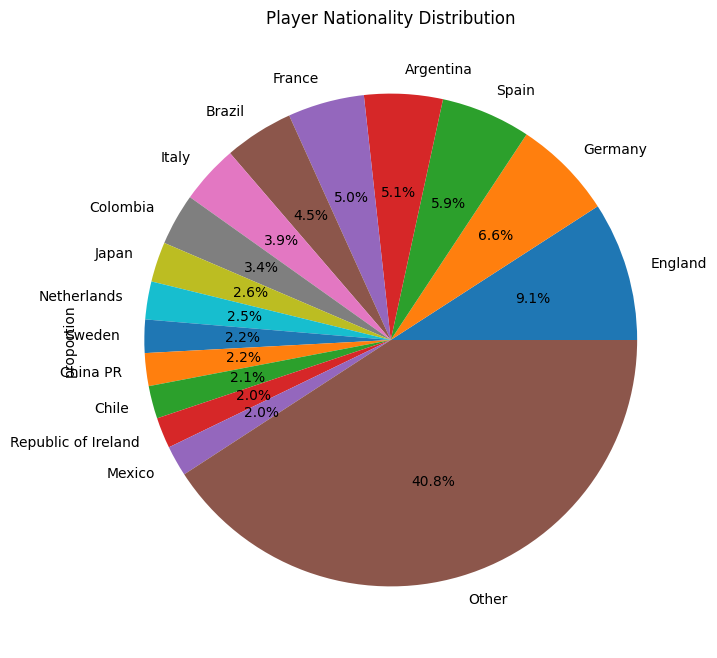

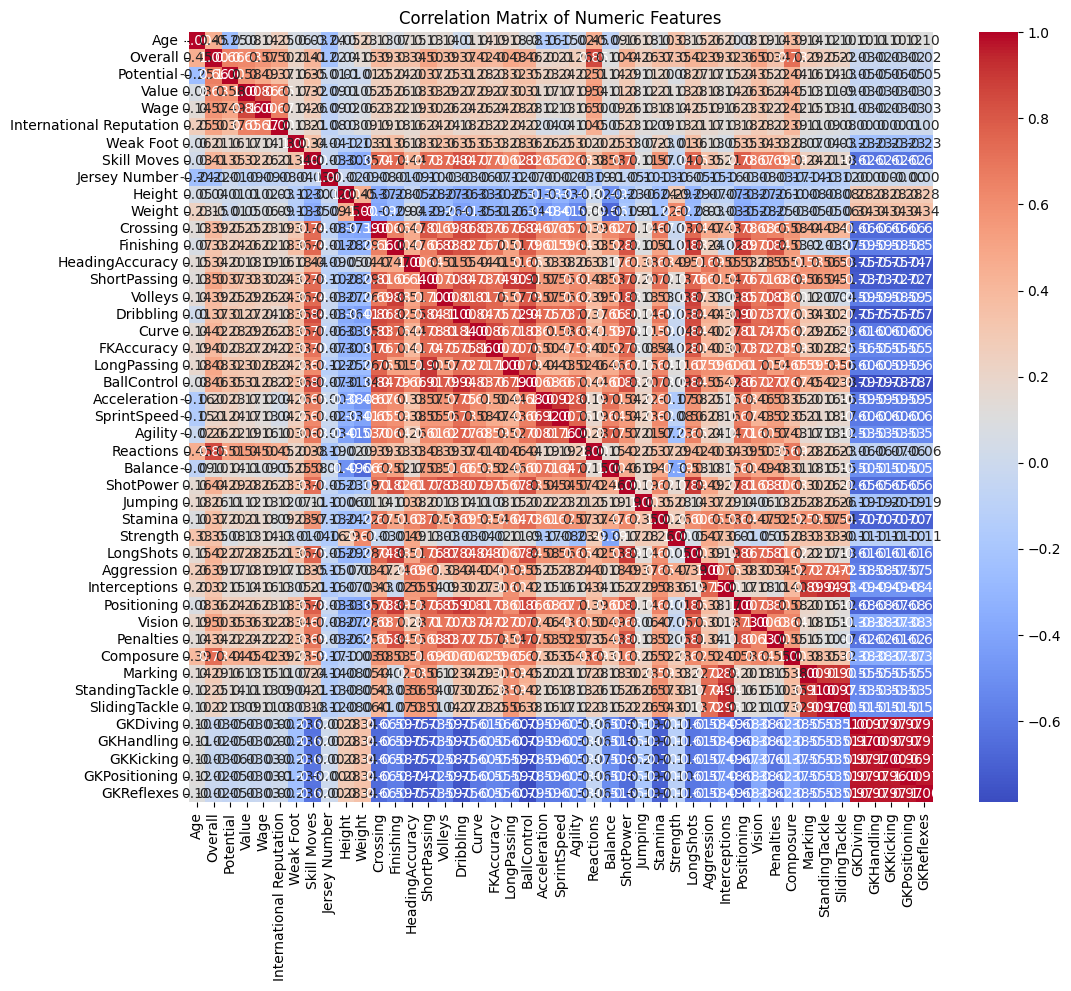

In [4]:
#stats
print("total number of players:", len(players))
print("number of unique clubs:", players['Club'].nunique())
print("number of unique nationalities:", players['Nationality'].nunique())
avg_wage = players.groupby("Club")["Wage"].mean().sort_values(ascending=False)
print("club with highest average wage:\n", avg_wage)
top_nationalities = players.groupby("Nationality")["Overall"].mean().sort_values(ascending=False).head(10)
top_nationalities.plot(kind='bar', figsize=(12,6), title="Top Nationalities by Average Overall Rating")
plt.ylabel("Average Overall Rating")
plt.show()
count = players['Nationality'].value_counts(normalize=True)*100
major = count[count > 2]
minor = count[count <= 2]
pie_data = major
pie_data['Other'] = minor.sum()
pie_data.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8), title="Player Nationality Distribution")
correlation_matrix = players[numeric_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")

To build my recommedation model, I'll first need to make all my catagorical features into numerics. I previously defined my catagorical columns, so I turned them into dummies. Since there are many nationalities and clubs present in the dataset, I'm going to have to add some weights so that these features dont make the dataset imbalanced. I'll use k-NearestNeighbor with the cosine distance as it is a very common model for this kind of system. KNN is simple, fast and direct way of finding similarity between values. For my purposes, I want to find the 5 most similar players to a player.

In [5]:
cata = players[categorical_cols].copy()
cata.drop(columns=['Name'], inplace=True)

dummies = pd.get_dummies(cata, drop_first=True)

nat_cols = dummies.filter(like="Nationality_").columns
dummies[nat_cols] = dummies[nat_cols] * 0.3

club_cols = dummies.filter(like="Club_").columns
dummies[club_cols] = dummies[club_cols] * 0.4

X = pd.concat([scaled_df, dummies], axis=1)

In [6]:
nn = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='cosine')
nn.fit(X)

,n_neighbors,6
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


My recommendation function takes in a name of player, and the number of similar players (by default 5). It will first check if the name is in the database, then it stores the row of that player entry, then it KNN is trained to find the k+1 most similar players (the first one is always the one bieng asked). We remove the first player, and finaly create a dataframe of the most similar players.

In [10]:
def Player_rec(name, k=5):
    if name not in players['Name'].values:
        return f"player {name} not fount"
    idx = players[players['Name'] == name].index[0]
    distances, indices = nn.kneighbors([X.iloc[idx]], n_neighbors=k+1)
    rec_indices = indices.flatten()[1:]
    rec_distances = distances.flatten()[1:]

    recommendations = players.iloc[rec_indices].copy()
    recommendations["distance"] = rec_distances

    return recommendations[["Name", "Club", "Wage", "Value", "Overall", "distance"]]

print("player reccomendations for 'Lionel Messi':")
recommendations = Player_rec("L. Messi", k=5)
print(recommendations)

player reccomendations for 'Lionel Messi':


c:\Users\holyw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


            Name               Club      Wage       Value  Overall  distance
5      E. Hazard            Chelsea  340000.0  93000000.0       91  0.024361
7      L. Suárez       FC Barcelona  455000.0  80000000.0       91  0.025338
32      Coutinho       FC Barcelona  340000.0  69500000.0       88  0.025572
28  J. Rodríguez  FC Bayern München  315000.0  69500000.0       88  0.028037
6      L. Modrić        Real Madrid  420000.0  67000000.0       91  0.028923



I wnat to find out if overall score cluster. First ill create a random sample of 500 get their row indices and convert them into arrays. Then I reduce some uncenessary dimensions, and finaly create a dataframe suitable for 2D vizualization. 

In [22]:
sample = players.sample(n=500, random_state=RANDOM_SEED)
sample_indeces = sample.index.tolist()
X_sample = X.iloc[sample_indeces].to_numpy()

pca = PCA(n_components=2, random_state=RANDOM_SEED)
x_pca = pca.fit_transform(X_sample)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, max_iter=3000)
x_tsne = tsne.fit_transform(X_sample)

plot_df = pd.DataFrame(
    {
        "x": x_tsne[:,0],
        "y": x_tsne[:,1],
        "Overall": sample["Overall"].values,
        "Name": sample["Name"].values
    }
)


KeyboardInterrupt: 

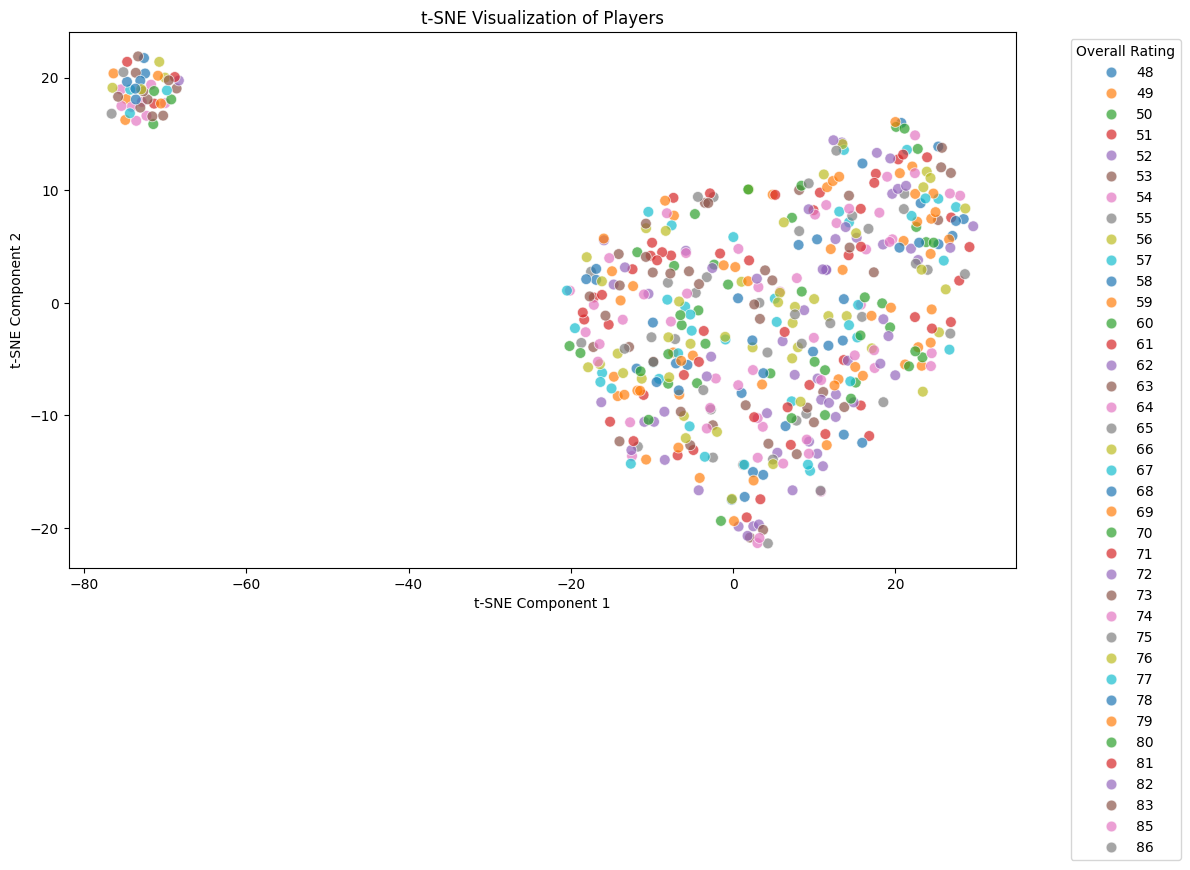

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=plot_df, x="x", y="y", hue="Overall", palette="tab10", s=60, alpha=0.7)
plt.title("t-SNE Visualization of Players")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Overall Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()